In [14]:
from dotenv import load_dotenv
import os

# Load the environment variables from the .env file
load_dotenv()

True

In [15]:
# #Setting up the LangSmith
# #For now, all runs will be stored in the "KGBot Testing - GPT4"
# #If you want to separate the traces to have a better control of specific traces.
# #Metadata as llm version and temperature can be obtained from traces.
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = (
    f"KGBot Testing - Interpreter_agent"  # Please update the name here if you want to create a new project for separating the traces.
)
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
from langsmith import Client

client = Client()

# #Check if the client was initialized
print(client)

Client (API URL: https://api.smith.langchain.com)


In [16]:
# langchain imports for agent and prompt handling
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser 
from langchain.prompts import BaseChatPromptTemplate
from langchain.utilities import SerpAPIWrapper
from langchain.chains.llm import LLMChain
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_tools_agent
from langchain import hub

# langgraph imports for prebuilt tool invocation
from langgraph.prebuilt import ToolInvocation
from langgraph.graph import StateGraph, END

# langchain_core imports for message handling and action schema
from langchain_core.messages import BaseMessage, HumanMessage, FunctionMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder 
from langchain.schema import AgentAction, AgentFinish, HumanMessage

# langchain output parser for OpenAI functions
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from codeinterpreterapi import CodeInterpreterSession, File
# typing imports for type hinting
from typing import Annotated, List, Tuple, Union,  Any, Dict, Optional, Sequence, TypedDict
import operator
import functools

# Standard library imports for JSON and regular expressions
import json
import re
from importlib import reload
import sparql  
reload(sparql)
# Custom imports for RDF graph manipulation and chemical, target, taxon, and SPARQL resolution
from RdfGraphCustom import RdfGraph
from smile_resolver import smiles_to_inchikey
from chemical_resolver import ChemicalResolver
from target_resolver import target_name_to_target_id
from taxon_resolver import TaxonResolver
from sparql import GraphSparqlQAChain

# langchain pydantic for base model definitions
from langchain.pydantic_v1 import BaseModel, Field

# langchain tools for base, structured tool definitions, and tool decorators
from langchain.tools import BaseTool, StructuredTool, tool

# Standard library import for object serialization
import pickle

import sys
import logging





In [17]:
####################### Instantiate the graph #######################

endpoint_url = 'https://enpkg.commons-lab.org/graphdb/repositories/ENPKG' #remove
#create function put to main
# init with the endpoint url
graph = RdfGraph(
    query_endpoint=endpoint_url,
    standard="rdf")

# #OR

# graph = RdfGraph(
#     query_endpoint=endpoint_url,
#     standard="rdf",
#     schema_file='../graphs/schema.ttl')


# save the graph on disk
with open('../graphs/graph.pkl', 'wb') as output_file:
    pickle.dump(graph, output_file)
    

####################### Load the graph from disk #######################
    
# # load the graph from disk
# with open('../graphs/graph.pkl', 'rb') as input_file:
#     graph = pickle.load(input_file)
    
print(graph.get_schema)

2024-03-26 15:25:51,630 - INFO - query 
    SELECT DISTINCT ?cls ?com ?label
        WHERE {
            ?cls a rdfs:Class . 
            OPTIONAL { ?cls rdfs:comment ?com }
            OPTIONAL { ?cls rdfs:label ?label }
        }
        GROUP BY ?cls ?com ?label
    
Adding classes to graph: 100%|██████████| 50/50 [00:11<00:00,  4.18it/s]
2024-03-26 15:26:03,709 - INFO - namespaces [('brick', 'https://brickschema.org/schema/Brick#'), ('csvw', 'http://www.w3.org/ns/csvw#'), ('dc', 'http://purl.org/dc/elements/1.1/'), ('dcat', 'http://www.w3.org/ns/dcat#'), ('dcmitype', 'http://purl.org/dc/dcmitype/'), ('dcterms', 'http://purl.org/dc/terms/'), ('dcam', 'http://purl.org/dc/dcam/'), ('doap', 'http://usefulinc.com/ns/doap#'), ('foaf', 'http://xmlns.com/foaf/0.1/'), ('geo', 'http://www.opengis.net/ont/geosparql#'), ('odrl', 'http://www.w3.org/ns/odrl/2/'), ('org', 'http://www.w3.org/ns/org#'), ('prof', 'http://www.w3.org/ns/dx/prof/'), ('prov', 'http://www.w3.org/ns/prov#'), ('qb', 'http:

The namespace prefixes are: [('brick', 'https://brickschema.org/schema/Brick#'), ('csvw', 'http://www.w3.org/ns/csvw#'), ('dc', 'http://purl.org/dc/elements/1.1/'), ('dcat', 'http://www.w3.org/ns/dcat#'), ('dcmitype', 'http://purl.org/dc/dcmitype/'), ('dcterms', 'http://purl.org/dc/terms/'), ('dcam', 'http://purl.org/dc/dcam/'), ('doap', 'http://usefulinc.com/ns/doap#'), ('foaf', 'http://xmlns.com/foaf/0.1/'), ('geo', 'http://www.opengis.net/ont/geosparql#'), ('odrl', 'http://www.w3.org/ns/odrl/2/'), ('org', 'http://www.w3.org/ns/org#'), ('prof', 'http://www.w3.org/ns/dx/prof/'), ('prov', 'http://www.w3.org/ns/prov#'), ('qb', 'http://purl.org/linked-data/cube#'), ('schema', 'https://schema.org/'), ('sh', 'http://www.w3.org/ns/shacl#'), ('skos', 'http://www.w3.org/2004/02/skos/core#'), ('sosa', 'http://www.w3.org/ns/sosa/'), ('ssn', 'http://www.w3.org/ns/ssn/'), ('time', 'http://www.w3.org/2006/time#'), ('vann', 'http://purl.org/vocab/vann/'), ('void', 'http://rdfs.org/ns/void#'), ('wgs

In [18]:
# Initial setup: defining the temperature for the model and specifying model IDs for GPT-4 usage
temperature = 0.3
model_id_gpt4 = "gpt-4"
model_id = "gpt-4-0125-preview"

# Create instances of the ChatOpenAI class for interacting with the GPT-4 models.
# These instances are configured for specific model versions, with retries and verbose logging enabled.
# defining gpt4 llm for supervisor
llm_gpt4 = ChatOpenAI(
    temperature=temperature, model=model_id_gpt4, max_retries=3, verbose=True, model_kwargs={
                        "top_p": 0.95,
                        }
)  # Instance for default GPT-4 model

llm = ChatOpenAI(
    temperature=temperature,
    model=model_id,  # This instance uses a specific GPT-4 turbo model.
    max_retries=3,
    verbose=True,
)  # Instance for GPT-4 0125-preview model.


# Setup a GraphSparqlQAChain instance for executing SPARQL queries against a knowledge graph.
# This instance utilizes the llm model for processing and the graph object for data querying.
sparql_chain = GraphSparqlQAChain.from_llm(llm_gpt4, graph=graph, verbose=True)

# Initialize chemical and taxon resolver tools with the llm model for specialized query processing.
chem_res = ChemicalResolver.from_llm(llm=llm, verbose=True)
taxon_res = TaxonResolver()


# Pydantic models for structured input to the resolver tools.
class ChemicalInput(BaseModel):
    query: str = Field(description="natural product compound string")


class SparqlInput(BaseModel):
    question: str = Field(description="the original question from the user")
    entities: str = Field(
        description="strings containing for all entities, entity name and the corresponding entity identifier"
    )


# Define a list of structured tools for chemical, taxon, target, and SMILES conversion resolution.
# def tools_resolver_creator():
tools_resolver = [
    StructuredTool.from_function(
        name="CHEMICAL_RESOLVER",
        func=chem_res.run,
        description="The function takes a natural product compound string as input and returns a InChIKey, if InChIKey not found, it returns the NPCClass, NPCPathway or NPCSuperClass.",
        args_schema=ChemicalInput,
    ),
    StructuredTool.from_function(
        name="TAXON_RESOLVER",
        func=taxon_res.query_wikidata,
        description="The function takes a taxon string as input and returns the wikidata ID.",
    ),
    StructuredTool.from_function(
        name="TARGET_RESOLVER",
        func=target_name_to_target_id,
        description="The function takes a target string as input and returns the ChEMBLTarget IRI.",
    ),
    StructuredTool.from_function(
        name="SMILE_CONVERTER",
        func=smiles_to_inchikey,
        description="The function takes a SMILES string as input and returns the InChIKey notation of the molecule.",
    ),
]


# Define a list for the SPARQL query runner tool, used for executing knowledge graph queries.
tool_sparql = [
    StructuredTool.from_function(
        name="SPARQL_QUERY_RUNNER",
        func=sparql_chain.run,
        description="The agent resolve the user's question by querying the knowledge graph database. Input should be a question and the resolved entities in the question. The output is the answer to the question and path to the file containing the SPARQL output.",
        args_schema=SparqlInput,
        # return_direct=True,
    )
]


# Generate a list of tool names for reference or display purposes.
tool_names = [
    tool.name for tool in tools_resolver
]  # List of tool names from the resolver tools.

#  Helper Utilities to create agent

In [19]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    """
    Creates an AgentExecutor with LLM, set of tools, and system prompt.

    This function initializes a chat prompt template with a system message, placeholders for messages,
    and an agent scratchpad. It then creates an agent using the specified LLM and tools,
    and wraps this agent in an AgentExecutor for execution.

    Parameters:
    - llm (ChatOpenAI): The language model to be used by the agent for generating responses.
    - tools (list): A list of tools (functions or utilities) that the agent can use to perform actions or generate responses.
    - system_prompt (str): A string that provides initial instructions or information to the agent. This is used to set up the context for the agent's operations.

    Returns:
    - AgentExecutor: An executor object that manages the execution of the agent, allowing the agent to process input and use tools as defined.
    """

    # Initialize a ChatPromptTemplate with a system message, placeholders for incoming messages, and an agent scratchpad.
    # This template structures the input to the language model, integrating static and dynamic content.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    # Create an agent using the provided language model, tools, and the structured prompt.
    # This agent can interact with users, process input, and use tools based on the prompt template.
    agent = create_openai_tools_agent(llm, tools, prompt)

    # Initialize an AgentExecutor to manage and execute the agent's operations.
    # The executor facilitates the interaction between the agent and the tools, handling execution logic.
    executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
    return executor

# Create Agent Supervisor


In [20]:
# Define a list of agent names that will be part of the supervisor system.
members = ["ENPKG_agent", "Sparql_query_runner", "Interpreter_agent"]

# Define the system prompt that outlines the role and responsibilities of the supervisor agent,
# including instructions on how to delegate tasks to specialized agents based on the user's question.
system_prompt = """You are a supervisor. As the supervisor, your primary role is to coordinate the flow of information between agents and ensure the appropriate processing of the user question based on its content. You have access to a team of specialized agents: {members}.

Here is a list of steps to help you accomplish your role:

Analyse the user question and delegate functions to the specialized agents below if needed:
If the question mentions any of the following entities: natural product compound, chemical name, taxon name, target, SMILES structure, or numerical value delegate the question to the ENPKG_agent. ENPKG_agent would provide resolved entities needed to generate SPARQL query. For example if the question mentions either caffeine, or Desmodium heterophyllum call ENPKG_agent.

If you have answers from the agent mentioned above, you provide those answers with the user question to the Sparql_query_runner.

If the question does not mention chemical name, taxon name, target name, nor SMILES structure, delegate the question to the agent Sparql_query_runner. The Sparql_query_runner agent will perform further processing and provide the path containing the SPARQL output.

If the Sparql_query_runner provides a SPARQL query and the path to the file containing the SPARQL output without directly providing the answer (implying that the answer is too long to be directly included), then delegate this information to the Interpreter_agent for further analysis and interpretation. Provide the Interpreter_agent with the question, SPARQL query, and the path to the file provided by the Sparql_query_runner. Await the Interpreter_agent's response for the final answer.

Once the Interpreter_agent has completed its task mark the process as FINISH. Do not call the Interpreter_agent again.

If the Sparql_query_runner agent provides a SPARQL query, the path to the file containing the SPARQL output and final answer to the question, and there is no immediate need for further interpretation, normally mark the process as FINISH. However, if there is a need to visualize the results (regardless of the length of the SPARQL output), also call the Interpreter_agent to generate the necessary plot, chart, or graph based on the SPARQL output. The need for visualization should be assessed based on the user's request or if the nature of the data implies that visualization would enhance understanding. Once the Interpreter_agent has completed its task mark the process as FINISH. Do not call the Interpreter_agent again.

For example, the user provides the following question: For features from Melochia umbellata in PI mode with SIRIUS annotations, get the ones for which a feature in NI mode with the same retention time has the same SIRIUS annotation. Since the question mentions Melochia umbellata you should firstly delegate it to the ENPKG_agent which would provide wikidata IRI with TAXON_RESOLVER tool, then, you should delegate the question together with the output generated by ENPKG_agent to the Sparql_query_runner agent. Afterwards, if the Sparql_query_runner agent provided the answer to the question, SPARQL query and path to the file containing the SPARQL output and there is no need to visualize the output you should mark the process as FINISH. If the Sparql_query_runner agent  provided only SPARQL query and path to the file you should call Interpreter_agent which would interpret the results provided by Sparql_query_runner to generate the final response to the question.

Avoid calling the same agent if this agent has already been called previously and provided the answer. For example, if you have called ENPKG_agent and it provided InChIKey for chemical compound do not call this agent again.

Always tell the user the SPARQL query that has been returned by the Sparql_query_runner.

If the agent does not provide the expected output mark the process as FINISH.

Remember, your efficiency in routing the questions accurately and collecting responses is crucial for the seamless operation of our system. If you don't know the answer to any of the steps, please say explicitly and help the user by providing a query that you think will be better interpreted.
"""


# Function to create a team supervisor agent that routes tasks based on user questions.
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """
    Configures and returns a supervisor agent setup with decision-making logic for task routing.

    The supervisor uses a provided language model (llm) to analyze user questions and decides whether to delegate
    the question to specialized agents (members), or to mark the process as finished based on predefined criteria.

    Parameters:
    - llm (ChatOpenAI): The language model to be used for processing and routing decisions.
    - system_prompt (str): A detailed prompt describing the supervisor's role and decision-making guidelines.
    - members (list): A list of specialized agents available for task delegation.

    Returns:
    - str: A configured prompt or agent setup that integrates routing logic for processing user questions.
    """
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Defining separate agents

In [21]:
# Define the system message for the entity resolution agent (resolver) responsible for processing user questions.
# This message includes instructions for the agent on how to handle different types of entities mentioned in questions.
system_message_resolver = """You are an entity resolution agent for the Sparql_query_runner. If this prompt has reached you, it is for a specific and significant reason. It is imperative that you read the instructions and details provided carefully and thoroughly.
You have access to the following tools:
{tool_names}
You should analyze the question and provide resolved entities for the entities mentioned in the question to the supervisor using the tools available to you. Here is a list of steps to help you accomplish your role:

If the question ask anything about any entities that could be natural product compound, find the relevant IRI to this chemical class using CHEMICAL_RESOLVER tool. Input is the chemical class name. For example, if salicin is mentioned in the question, provide its IRI using CHEMICAL_RESOLVER, input is salicin. 

If a taxon is mentioned, find what is its wikidata IRI with TAXON_RESOLVER. Input is the taxon name. For example, if the question mentions acer saccharum, you should provide its wikidata IRI using TAXON_RESOLVER tool. 

If a target is mentioned, find the ChEMBLTarget IRI of the target using TARGET_RESOLVER tool. Input is the target name.

If a SMILE structure is mentioned, find what is the InChIKey notation of the molecule using SMILE_CONVERTER tool. Input is the SMILE structure. For example, if there is a string with similar structure to CCC12CCCN3C1C4(CC3) in the question, provide it to SMILE_CONVERTER.
        
Give me units relevant to numerical values in this question. Return nothing if units for value is not provided.
Be sure to say that these are the units of the quantities found in the knowledge graph.
Here is the list of units to find:
    "retention time": "minutes",
    "activity value": null, 
    "feature area": "absolute count or intensity", 
    "relative feature area": "normalized area in percentage", 
    "parent mass": "ppm (parts-per-million) for m/z",
    "mass difference": "delta m/z", 
    "cosine": "score from 0 to 1. 1 = identical spectra. 0 = completely different spectra"

 You do not have to answer the question, your task is to provide resolved entities mentioned in the question using the tools available to you. For example, if the question mentions Hibiscus rosa-sinensis provide its wikidata IRI using TAXON_RESOLVER tool.
 
 You are required to submit only the final answer to the supervisor.
        
""".format(
    tool_names="\n".join(tool_names)
)


# Create an agent for entity resolution based on the instructions provided in `system_message_resolver`.
enpkg_agent = create_agent(llm_gpt4, tools_resolver, system_message_resolver)


# Create an agent for running SPARQL queries based on user requests and resolved entities provided by other agents.
system_message_sparql = """You are SPARQL query runner, you take as input the user request and resolved entities provided by other agents, generate a SPARQL query, run it on the knowledge graph and answer to the question using SPARQL_QUERY_RUNNER tool. Specifically, when providing user request and resolved entities to the SPARQL_QUERY_RUNNER tool, format them as 'entity from the question has entity type entity resolution'. For example, you should provide the following input: catharanthus roseus has the Wikidata IRI https://www.wikidata.org/wiki/Q161093. Ensure this format is strictly adhered to for effective querying.  

If the output of the SPARQL_QUERY_RUNNER tool consists of only generated SPARQL query and path to the file containing the SPARQL output, you will need to generate a dictionary as output from your process. This dictionary should contain exactly three key-value pairs:
question: The key should be a string named 'question' and the value should be the natural language question you were asked to translate into a SPARQL query.
generated_sparql_query: The key should be a string named 'generated_sparql_query' and the value should be the SPARQL query you generated based on the natural language question.
file_path: The key should be a string named 'file_path' and the value should be the absolute path to the file where the generated SPARQL query is saved. In this case provide the generated dictionary to the supervisor which would call the Interpreter agent to further interpret the results.

If the output of the SPARQL_QUERY_RUNNER tool consists of generated SPARQL query, path to the file containing the SPARQL output and the SPARQL output then you need to generate the final answer to the question based on the SPARQL output. Provide the final answer to the question together with the dictionary containing the question, generated_sparql_query and file_path. The dictionary should contain exactly three key-value pairs:
question: The key should be a string named 'question' and the value should be the natural language question you were asked to translate into a SPARQL query.
generated_sparql_query: The key should be a string named 'generated_sparql_query' and the value should be the SPARQL query you generated based on the natural language question.
file_path: The key should be a string named 'file_path' and the value should be the absolute path to the file where the generated SPARQL query is saved.
 Provide the final answer to the supervisor.
"""

sparql_query_agent = create_agent(llm, tool_sparql, system_message_sparql)

## Defining interpreter agent

In [22]:
interpreter_session = CodeInterpreterSession()


class InterpreterInput(BaseModel):
    question: str = Field(description="the original question from the user")
    generated_sparql_query: str = Field(description="the generated SPARQL query")
    file_path: str = Field(
        description="file path where result of generated SPARQL query is stored"
    )


def interpreter_logic(question, generated_sparql_query, file_path) -> None:
    """Interprets the results of a SPARQL query based on user's question.

    Args:
        question (str): The original question from the user.
        generated_sparql_query (str): The generated SPARQL query.
        file_path (str): The file path where the result of the generated SPARQL query is stored.

    Returns:
        None: Outputs the response after interpreting the SPARQL results.
    """
    # context manager for start/stop of the session
    # define the user request
    print(f"Interpreting {question}")
    print(f"SPARQL query: {generated_sparql_query}")
    print(f"File path: {file_path}")
    with CodeInterpreterSession() as session:
        user_request = f"""You are an interpreter agent. Your task is to analyze the output related to a SPARQL query, which could be in two forms:
         If the output of the Sparql_query_runner agent is only the dictionary containing question: "{question}", generated SPARQL query: "{generated_sparql_query}" which was used to query the knowledge graph to answer to the question and path: "{file_path}" containing the SPARQL output then you should review the provided dataset from the file and SPARQL query to provide a clear, concise answer to the question. Additionally, if visualization of the results is necessary (e.g., when the SPARQL output is large or complex), you should provide an appropriate visualization, such as a bar chart, diagram, or plot, to effectively communicate the answer.
         If the output of the Sparql_query_runner agent contains the answer to the question together with the dictionary containing the question: "{question}", generated SPARQL query: "{generated_sparql_query}" and path: "{file_path}", then you should analyze this output and provide visualization of the answer to the question. 
         The type of visualization – bar chart, diagram, or plot – will depend on the nature of the SPARQL output and the best way to represent the answer to the question clearly.
         Submit only the final answer to the supervisor. Indicate the format of the dataset for appropriate handling. """
        files = [
            File.from_path(file_path),
        ]

        # generate the response
        response = session.generate_response(user_request, files=files)
        # output the response (text + image)
        response.show()
        return response.content


interpreter_tool = StructuredTool.from_function(
    name="INTERPRETER_TOOL",
    func=interpreter_logic,
    description="The function takes an original user question, generated sparql query, and generated sparql query result stored in file_path and returns interpreted answer content",
    args_schema=InterpreterInput,
)
system_message_interpreter = """You are an interpreter agent. Your main role is to analyze outputs from the Sparql_query_runner agent using the INTERPRETER_TOOL. The outputs from the Sparql_query_runner agent can be of two types:

The output is a dictionary containing 'question', 'generated_sparql_query', and 'file_path'. This typically happens when the Sparql_query_runner agent has executed a query to fetch results for a complex question. Your task is to provide this dictionary directly to the INTERPRETER_TOOL to get a concise answer. Ensure you format the dictionary correctly and include all necessary information so the INTERPRETER_TOOL can process it efficiently.

The output directly contains the answer to the question but still comes within a dictionary that includes the 'question', 'generated_sparql_query', and 'file_path'. Even if the answer is directly provided, your role remains to pass this entire dictionary to the INTERPRETER_TOOL. The tool requires this structured input to validate and format the final answer properly.

In both scenarios, your primary function is to ensure that the INTERPRETER_TOOL receives the necessary information in a structured dictionary format. This allows the tool to analyze the SPARQL query's output thoroughly and provide a clear, concise answer to the initial question."""

interpreter_agent = create_agent(llm, [interpreter_tool], system_message_interpreter)

# Construct Graph

In [23]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


# function to define nodes
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


# creating nodes for each agent
enpkg_node = functools.partial(agent_node, agent=enpkg_agent, name="ENPKG_agent")
sparql_query_node = functools.partial(
    agent_node, agent=sparql_query_agent, name="Sparql_query_runner"
)
interpreter_agent_node = functools.partial(
    agent_node, agent=interpreter_agent, name="Interpreter_agent"
)
supervisor_agent = create_team_supervisor(llm_gpt4, system_prompt, members)

# creating the workflow and adding nodes to it
workflow = StateGraph(AgentState)
workflow.add_node("ENPKG_agent", enpkg_node)
workflow.add_node("Sparql_query_runner", sparql_query_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("Interpreter_agent", interpreter_agent_node)
# connect all the edges in the graph
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")

workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "ENPKG_agent": "ENPKG_agent",
        "Sparql_query_runner": "Sparql_query_runner",
        "Interpreter_agent": "Interpreter_agent",
        "FINISH": END,
    },
)

workflow.set_entry_point("supervisor")
app = workflow.compile()

In [24]:
q1 = "How many features (pos ionization and neg ionization modes) have the same SIRIUS/CSI:FingerID and ISDB annotation by comparing the InCHIKey of the annotations?"
q1_bis = "How many features (pos ionization and neg ionization modes) have the same SIRIUS/CSI:FingerID and ISDB annotation by comparing the InCHIKey2D of the annotations?"
q2 = "Which extracts have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids? Group by extract."
q3 = "Among the structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract taxon , which ones contain an aspidospermidine substructure?"
q4 = "Among the SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract, which ones are reported in the Tabernaemontana genus in Wikidata?"
q5 = "Which compounds have annotations with chembl assay results indicating reported activity against T. cruzi by looking at the cosmic, zodiac and taxo scores?"
q5_bis = "Which compounds have annotations with chembl assay results indicating reported activity against Trypanosoma cruzi by looking at the cosmic, zodiac and taxo scores?"
q6 = "Filter the pos ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS to keep the ones for which a feature in neg ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm)."
q7 = "For features from the Melochia umbellata taxon in pos ionization mode with SIRIUS annotations, get the ones for which a feature in neg ionization mode with the same retention time (+/- 3 seconds) has the same SIRIUS annotation by comparing the InCHIKey 2D. Return the features, retention times, and InChIKey2D"
q8 = "Which features were annotated as 'Tetraketide meroterpenoids' by SIRIUS, and how many such features were found for each species and plant part?"
q9 = "What are all distinct submitted taxons for the extracts in the knowledge graph?"
q10 = "What are the taxons, lab process and label (if one exists) for each sample? Sort by sample and then lab process"
q11 = "Count all the species per family in the collection"

q12 = "Taxons can be found in enpkg:LabExtract. Find the best URI of the Taxon in the context of this question : \n Among the structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract taxon , which ones contain an aspidospermidine substructure, CCC12CCCN3C1C4(CC3)C(CC2)NC5=CC=CC=C45?"
q13 = "Which compounds annotated in the active extract of Melochia umbellata have activity against Trypanosoma cruzi reported (in ChEMBL)?"
q14 = "What are the variations in the concentration of key active compounds found in Tabernaemontana coffeoides seed extracts across different sample collections?"
q15 = "Which compounds are detected most in Tabernaemontana genus?"
q16 = (
    "What are the most frequently detected compounds in the leaves of the Tabernaemontana genus? "
    " over of features annotated as certain chemical classes vary across different Tabernaemontana genus extracts in the ENPKG, with a focus on features identified in positive ionization mode and annotated by CANOPUS with a probability score above 0.5?"
)
q17 = " For all the plant extracts plot the distribution of number of features per sample retention time vs mass to charge ratio"
q18 = "What are the most frequently observed chemical compounds in Tabernaemontana genus? Provide a bar chart."

In [12]:
import requests


def test_sparql_endpoint(endpoint):
    """
    Tests the validity of a SPARQL endpoint by sending a simple ASK query.
    Parameters:
    - endpoint (str): The URL of the SPARQL endpoint to test.
    Returns:
    - bool: True if the endpoint is valid and responsive, False otherwise.
    """
    test_query = {"query": "ASK WHERE { ?s ?p ?o } LIMIT 1"}
    headers = {"Accept": "application/sparql-results+json"}
    try:
        response = requests.get(endpoint, params=test_query, headers=headers)
        response.raise_for_status()  # Ensures HTTP request was successful
        # Validate response format
        if response.json() is not None:
            return True
        else:
            print("The endpoint did not return a valid SPARQL result.")
            return False

    except requests.RequestException as e:
        print(f"Failed to connect to the endpoint: {e}")
        return False

In [123]:
result = test_sparql_endpoint(endpoint_url)

2024-03-21 14:38:03,402 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-21 14:38:04,947 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `TAXON_RESOLVER` with `{'taxon_name': 'Melochia umbellata'}`


wikidata IRI is http://www.wikidata.org/entity/Q6813281

2024-03-21 14:38:09,112 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entity for the taxon "Melochia umbellata" is the wikidata IRI: http://www.wikidata.org/entity/Q6813281.

The units relevant to numerical values in this question are:
- "retention time": "seconds",
- "parent mass": "ppm (parts-per-million) for m/z".

> Finished chain.


2024-03-21 14:38:13,642 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-21 14:38:15,709 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'Filter the pos ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS to keep the ones for which a feature in neg ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm).', 'entities': 'taxon: http://www.wikidata.org/entity/Q6813281'}`




> Entering new GraphSparqlQAChain chain...


/Users/madinabekbergenova/anaconda3/envs/kgai/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
2024-03-21 14:38:46,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>

SELECT ?posFeature ?negFeature
WHERE {
    ?rawMaterial ns1:has_wd_id wd:Q6813281 .
    ?rawMaterial ns1:has_lab_process ?labExtract .
    ?labExtract ns1:has_LCMS ?posAnalysis .
    ?posAnalysis a ns1:LCMSAnalysisPos .
    ?posAnalysis ns1:has_lcms_feature_list ?posFeatureList .
    ?posFeatureList ns1:has_lcms_feature ?posFeature .
    ?posFeature ns1:has_sirius_annotation ?posAnnotation .
    ?posAnnotation ns1:has_sirius_adduct "[M+H]+" .
    ?posFeature ns1:has_retention_time ?posRetentionTime .
    ?posFeature ns1:has_parent_mass ?posMass .

    ?labExtract ns1:has_LCMS ?negAnalysis .
    ?negAnalysis a ns1:LCMSAnalysisNeg .
    ?negAnalysis ns1:has_lcms_feature_list ?negFeatureList .
    ?negFeatureList ns1:has_lcms_feature ?negFeature .
    ?negFeature ns1:has_sirius_an

2024-03-21 14:38:49,750 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The SPARQL query has been successfully generated and executed to filter the positive ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS. It keeps the ones for which a feature in negative ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm).

Here is the information you requested:

- **Question**: Filter the pos ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS to keep the ones for which a feature in neg ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm).
- **Generated SPARQL Query**:
```sparql
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>

SELECT ?posFeature ?negFeature
WHERE {
    ?rawMaterial ns1:has_wd_id wd:Q6813

2024-03-21 14:39:44,544 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-21 14:39:46,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `INTERPRETER_TOOL` with `{'file_path': '/var/folders/20/4kgcw5656h12ss_nj18mndwm0000gn/T/tmpkthygr1l.csv', 'generated_sparql_query': 'PREFIX ns1: <https://enpkg.commons-lab.org/kg/>\nPREFIX ns2: <https://enpkg.commons-lab.org/module/>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\nPREFIX wd: <http://www.wikidata.org/entity/>\n\nSELECT ?posFeature ?negFeature\nWHERE {\n    ?rawMaterial ns1:has_wd_id wd:Q6813281 .\n    ?rawMaterial ns1:has_lab_process ?labExtract .\n    ?labExtract ns1:has_LCMS ?posAnalysis .\n    ?posAnalysis a ns1:LCMSAnalysisPos .\n    ?posAnalysis ns1:has_lcms_feature_list ?posFeatureList .\n    ?posFeatureList ns1:has_lcms_feature ?posFeature .\n    ?posFeature ns1:has_sirius_annotation ?posAnnotation .\n    ?posAnnotation ns1:has_sirius_adduct "[M+H]+" .\n    ?posFeature ns1:has_retention_time ?posRetentionTime .\n    ?posFeature ns1:has_parent_mass ?posMass .\n\n    ?labExtract ns1:has_LCMS ?negAnalysis .\n    ?negAnalysis a ns1:LCMSAnalysisNeg .\n  

2024-03-21 14:40:20,818 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/Users/madinabekbergenova/anaconda3/envs/kgai/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `predict` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
2024-03-21 14:40:23,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-21 14:40:27,998 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-21 14:40:30,627 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AI:  The bar chart above shows the count of positive and negative ionization mode features for the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS. This visualization provides a clear comparison between the two types of features based on the SPARQL query results.

If you need further analysis or a different type of visualization, please let me know.
File:  image-93e6b4a7-0b19-4845-bfc0-583745448538.png


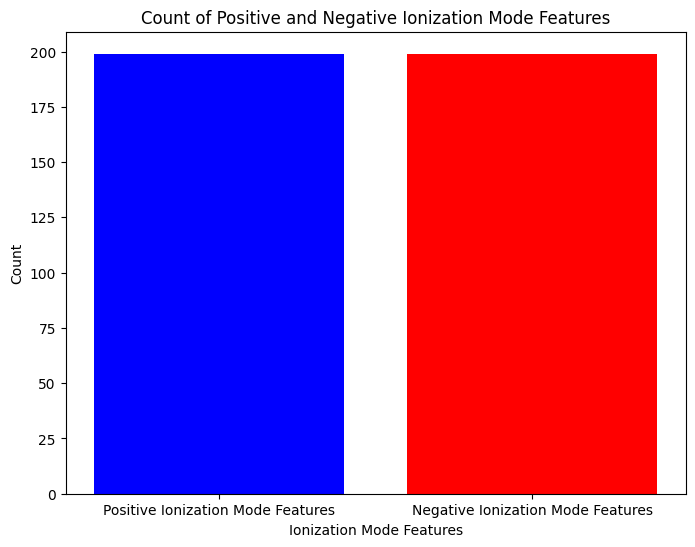

KeyboardInterrupt: 

In [12]:
for s in app.stream(
    {"messages": [HumanMessage(content=q6)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

In [25]:
for s in app.stream(
    {"messages": [HumanMessage(content=q4)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

2024-03-26 15:26:22,863 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-26 15:26:24,031 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `TAXON_RESOLVER` with `{'taxon_name': 'Tabernaemontana coffeoides'}`


wikidata IRI is http://www.wikidata.org/entity/Q15376858

2024-03-26 15:26:27,023 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entity for "Tabernaemontana coffeoides" is the Wikidata IRI: http://www.wikidata.org/entity/Q15376858.

> Finished chain.


2024-03-26 15:26:30,251 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-26 15:26:31,653 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'Among the SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract, which ones are reported in the Tabernaemontana genus in Wikidata?', 'entities': 'Tabernaemontana coffeoides has the Wikidata IRI http://www.wikidata.org/entity/Q15376858.'}`




> Entering new GraphSparqlQAChain chain...


2024-03-26 15:26:44,245 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns2: <https://enpkg.commons-lab.org/kg/>
PREFIX wd: <http://www.wikidata.org/entity/>
SELECT ?annotation
WHERE {
    ?rawMaterial a ns2:RawMaterial ;
                 ns2:has_wd_id wd:Q15376858 ;
                 ns2:has_lab_process ?labExtract .
    ?labExtract ns2:has_LCMS ?lcmsAnalysis .
    ?lcmsAnalysis ns2:has_sirius_annotation ?annotation .
    ?annotation ns2:has_InChIkey2D ?inchikey .
    ?inchikey ns2:has_wd_id ?wikidataID .
    FILTER(STRSTARTS(STR(?wikidataID), "http://www.wikidata.org/entity/Q"))
}
JSON data is empty or not in the expected format.
Saving results to file:  None

> Finished chain.
{'query': 'PREFIX ns2: <https://enpkg.commons-lab.org/kg/>\nPREFIX wd: <http://www.wikidata.org/entity/>\nSELECT ?annotation\nWHERE {\n    ?rawMaterial a ns2:RawMaterial ;\n                 ns2:has_wd_id wd:Q15376858 ;\n                 ns2:has_lab_process ?labExtract .\n    ?labExtract ns2:has_LCMS ?lcmsAnalysis .\n    ?lcmsAnalysis ns2:has_sirius_annotati

2024-03-26 15:26:45,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Based on the query executed, there are no SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract reported in the Tabernaemontana genus in Wikidata.

Here are the details of the process:
- **Question:** Among the SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract, which ones are reported in the Tabernaemontana genus in Wikidata?
- **Generated SPARQL Query:**
```sparql
PREFIX ns2: <https://enpkg.commons-lab.org/kg/>
PREFIX wd: <http://www.wikidata.org/entity/>
SELECT ?annotation
WHERE {
    ?rawMaterial a ns2:RawMaterial ;
                 ns2:has_wd_id wd:Q15376858 ;
                 ns2:has_lab_process ?labExtract .
    ?labExtract ns2:has_LCMS ?lcmsAnalysis .
    ?lcmsAnalysis ns2:has_sirius_annotation ?annotation .
    ?annotation ns2:has_InChIkey2D ?inchikey .
    ?inchikey ns2:has_wd_id ?wikidataID .
    FILTER(STRSTARTS(STR(?wikidataID), "http://www.wikidata.org/entity/Q"))
}
```
- **File Path:** The

2024-03-26 15:27:08,817 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__end__': {'messages': [HumanMessage(content='Among the SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract, which ones are reported in the Tabernaemontana genus in Wikidata?'), HumanMessage(content='The resolved entity for "Tabernaemontana coffeoides" is the Wikidata IRI: http://www.wikidata.org/entity/Q15376858.', name='ENPKG_agent'), HumanMessage(content='Based on the query executed, there are no SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract reported in the Tabernaemontana genus in Wikidata.\n\nHere are the details of the process:\n- **Question:** Among the SIRIUS structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract, which ones are reported in the Tabernaemontana genus in Wikidata?\n- **Generated SPARQL Query:**\n```sparql\nPREFIX ns2: <https://enpkg.commons-lab.org/kg/>\nPREFIX wd: <http://www.wikidata.org/entity/>\nSELECT ?annotation\nWHERE {\n    ?rawMater

In [13]:
for s in app.stream(
    {"messages": [HumanMessage(content=q3)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

2024-03-26 14:56:10,274 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-26 14:56:11,227 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `TAXON_RESOLVER` with `{'taxon_name': 'Tabernaemontana coffeoides'}`


wikidata IRI is http://www.wikidata.org/entity/Q15376858

2024-03-26 14:56:14,238 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `CHEMICAL_RESOLVER` with `{'query': 'aspidospermidine'}`




> Entering new ChemicalResolver chain...
InChIKey is aspidospermidine: InChIKey=YAAIPCQYJYPITK-UHFFFAOYSA-N

> Finished chain.
InChIKey is aspidospermidine: InChIKey=YAAIPCQYJYPITK-UHFFFAOYSA-N

2024-03-26 14:56:16,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entities are:

1. Tabernaemontana coffeoides: http://www.wikidata.org/entity/Q15376858
2. Aspidospermidine: InChIKey=YAAIPCQYJYPITK-UHFFFAOYSA-N

> Finished chain.


2024-03-26 14:56:19,993 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-26 14:56:24,678 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'Among the structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract taxon , which ones contain an aspidospermidine substructure?', 'entities': 'Tabernaemontana coffeoides+taxon+http://www.wikidata.org/entity/Q15376858; Aspidospermidine+InChIKey+YAAIPCQYJYPITK-UHFFFAOYSA-N'}`




> Entering new GraphSparqlQAChain chain...


/Users/madinabekbergenova/anaconda3/envs/kgai/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
2024-03-26 14:56:46,798 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns1: <https://enpkg.commons-lab.org/module/>
PREFIX ns2: <https://enpkg.commons-lab.org/kg/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?annotation
WHERE {
    ?taxon rdfs:label "Tabernaemontana coffeoides" .
    ?taxon ns2:has_lab_process ?extract .
    ?extract ns2:has_sirius_annotation ?annotation .
    ?annotation ns2:has_InChIkey2D ?inchikey .
    ?inchikey rdfs:label "YAAIPCQYJYPITK-UHFFFAOYSA-N" .
}
JSON data is empty or not in the expected format.
Saving results to file:  None

> Finished chain.
{'query': 'PREFIX ns1: <https://enpkg.commons-lab.org/module/>\nPREFIX ns2: <https://enpkg.commons-lab.org/kg/>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\n\nSELECT ?annotation\nWHERE {\n    ?taxon rdfs:label "Tabernaemontana coffeoides" .\n    ?taxon ns2:has_lab_process ?extract .\n    ?extract ns2:has_sirius_annotation ?annotation .\n  

2024-03-26 14:56:47,844 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The query did not return any structural annotations from the Tabernaemontana coffeoides seeds extract taxon that contain an aspidospermidine substructure. It appears there are no matching records in the database for this specific query.

Here are the details of the SPARQL query executed:

```sparql
PREFIX ns1: <https://enpkg.commons-lab.org/module/>
PREFIX ns2: <https://enpkg.commons-lab.org/kg/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?annotation
WHERE {
    ?taxon rdfs:label "Tabernaemontana coffeoides" .
    ?taxon ns2:has_lab_process ?extract .
    ?extract ns2:has_sirius_annotation ?annotation .
    ?annotation ns2:has_InChIkey2D ?inchikey .
    ?inchikey rdfs:label "YAAIPCQYJYPITK-UHFFFAOYSA-N" .
}
```

No annotations were found that match the criteria.

> Finished chain.


2024-03-26 14:57:03,384 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__end__': {'messages': [HumanMessage(content='Among the structural annotations from the Tabernaemontana coffeoides (Apocynaceae) seeds extract taxon , which ones contain an aspidospermidine substructure?'), HumanMessage(content='The resolved entities are:\n\n1. Tabernaemontana coffeoides: http://www.wikidata.org/entity/Q15376858\n2. Aspidospermidine: InChIKey=YAAIPCQYJYPITK-UHFFFAOYSA-N', name='ENPKG_agent'), HumanMessage(content='The query did not return any structural annotations from the Tabernaemontana coffeoides seeds extract taxon that contain an aspidospermidine substructure. It appears there are no matching records in the database for this specific query.\n\nHere are the details of the SPARQL query executed:\n\n```sparql\nPREFIX ns1: <https://enpkg.commons-lab.org/module/>\nPREFIX ns2: <https://enpkg.commons-lab.org/kg/>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\n\nSELECT ?annotation\nWHERE {\n    ?taxon rdfs:label 

In [257]:
for s in app.stream(
    {"messages": [HumanMessage(content=q7)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

2024-03-15 14:40:59,153 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 14:41:00,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `TAXON_RESOLVER` with `{'taxon_name': 'Melochia umbellata'}`


wikidata IRI is http://www.wikidata.org/entity/Q6813281

2024-03-15 14:41:01,997 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entity for the taxon "Melochia umbellata" is the Wikidata IRI: http://www.wikidata.org/entity/Q6813281

The units relevant to numerical values in this question are:
- "retention time": "seconds"

> Finished chain.


2024-03-15 14:41:05,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 14:41:06,730 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'For features from the Melochia umbellata taxon in pos ionization mode with SIRIUS annotations, get the ones for which a feature in neg ionization mode with the same retention time (+/- 3 seconds) has the same SIRIUS annotation by comparing the InCHIKey 2D. Return the features, retention times, and InChIKey2D', 'entities': 'Melochia umbellata: http://www.wikidata.org/entity/Q6813281'}`




> Entering new GraphSparqlQAChain chain...


2024-03-15 14:41:29,529 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?featurePos ?retentionTimePos ?InChIKey2DPos ?featureNeg ?retentionTimeNeg ?InChIKey2DNeg
WHERE {
    ?rawMaterial ns1:has_wd_id <http://www.wikidata.org/entity/Q6813281> .
    ?rawMaterial ns1:has_lab_process ?labExtract .
    ?labExtract ns1:has_LCMS ?lcmsAnalysisPos .
    ?lcmsAnalysisPos a ns1:LCMSAnalysisPos .
    ?lcmsAnalysisPos ns1:has_lcms_feature_list ?lcmsFeatureListPos .
    ?lcmsFeatureListPos ns1:has_lcms_feature ?featurePos .
    ?featurePos ns1:has_retention_time ?retentionTimePos .
    ?featurePos ns1:has_sirius_annotation ?siriusAnnotationPos .
    ?siriusAnnotationPos ns1:has_InChIkey2D ?InChIKey2DPos .
    
    ?labExtract ns1:has_LCMS ?lcmsAnalysisNeg .
    ?lcmsAnalysisNeg a ns1:LCMSAnalysisNeg .
    ?lcmsAnalysisNeg ns1:has_lcms_feature_list ?lcmsFeatureListNeg .
    ?lcmsFeatureListNeg ns1:h

2024-03-15 14:41:32,714 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The SPARQL query has been successfully generated and executed to find features from the Melochia umbellata taxon in positive ionization mode with SIRIUS annotations, which have a corresponding feature in negative ionization mode with the same retention time (±3 seconds) and the same SIRIUS annotation by comparing the InCHIKey 2D. The results include the features, retention times, and InChIKey2D.

Here is the information you requested:

- **Generated SPARQL Query:**
```sparql
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?featurePos ?retentionTimePos ?InChIKey2DPos ?featureNeg ?retentionTimeNeg ?InChIKey2DNeg
WHERE {
    ?rawMaterial ns1:has_wd_id <http://www.wikidata.org/entity/Q6813281> .
    ?rawMaterial ns1:has_lab_process ?labExtract .
    ?labExtract ns1:has_LCMS ?lcmsAnalysisPos .
    ?lcmsAnalysisPos a ns1:LCMSAnalysisPos .
    ?lcmsAnalysisPos ns1:has_lcms_feature_list 

2024-03-15 14:42:06,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 14:42:13,616 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `INTERPRETER_TOOL` with `{'file_path': '/var/folders/20/4kgcw5656h12ss_nj18mndwm0000gn/T/tmpjr_a9awh.csv', 'generated_sparql_query': 'PREFIX ns1: <https://enpkg.commons-lab.org/kg/>\nPREFIX ns2: <https://enpkg.commons-lab.org/module/>\nPREFIX xsd: <http://www.w3.org/2001/XMLSchema#>\n\nSELECT ?featurePos ?retentionTimePos ?InChIKey2DPos ?featureNeg ?retentionTimeNeg ?InChIKey2DNeg\nWHERE {\n    ?rawMaterial ns1:has_wd_id <http://www.wikidata.org/entity/Q6813281> .\n    ?rawMaterial ns1:has_lab_process ?labExtract .\n    ?labExtract ns1:has_LCMS ?lcmsAnalysisPos .\n    ?lcmsAnalysisPos a ns1:LCMSAnalysisPos .\n    ?lcmsAnalysisPos ns1:has_lcms_feature_list ?lcmsFeatureListPos .\n    ?lcmsFeatureListPos ns1:has_lcms_feature ?featurePos .\n    ?featurePos ns1:has_retention_time ?retentionTimePos .\n    ?featurePos ns1:has_sirius_annotation ?siriusAnnotationPos .\n    ?siriusAnnotationPos ns1:has_InChIkey2D ?InChIKey2DPos .\n    \n    ?labExtract ns1:has_LCMS ?lcmsAnalysisNeg .\

2024-03-15 14:42:49,029 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-15 14:42:50,131 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-15 14:42:54,340 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-15 14:42:55,006 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-15 14:42:57,130 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AI:  The analysis of the dataset based on the SPARQL query reveals 115 rows of data containing the features, retention times, and InChIKey2D values for both positive and negative ionization modes.

If visualization is required to effectively communicate the answer, please let me know the specific type of visualization you would like to see, such as a bar chart, diagram, or plot.
The analysis of the dataset based on the SPARQL query reveals 115 rows of data containing the features, retention times, and InChIKey2D values for both positive and negative ionization modes.

If visualization is required to effectively communicate the answer, please let me know the specific type of visualization you would like to see, such as a bar chart, diagram, or plot.

2024-03-15 14:44:16,375 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The analysis of the dataset based on the SPARQL query reveals that there are 115 rows of data containing the features, retention times, and InChIKey2D values for both positive and negative ionization modes. This indicates that there are 115 instances where features from the Melochia umbellata taxon in positive ionization mode with SIRIUS annotations have a corresponding feature in negative ionization mode with the same retention time (±3 seconds) and the same SIRIUS annotation by comparing the InCHIKey 2D.

If you need further details or a specific visualization of this data, please let me know how you would like the information presented.

> Finished chain.


2024-03-15 14:44:28,462 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__end__': {'messages': [HumanMessage(content='For features from the Melochia umbellata taxon in pos ionization mode with SIRIUS annotations, get the ones for which a feature in neg ionization mode with the same retention time (+/- 3 seconds) has the same SIRIUS annotation by comparing the InCHIKey 2D. Return the features, retention times, and InChIKey2D'), HumanMessage(content='The resolved entity for the taxon "Melochia umbellata" is the Wikidata IRI: http://www.wikidata.org/entity/Q6813281\n\nThe units relevant to numerical values in this question are:\n- "retention time": "seconds"', name='ENPKG_agent'), HumanMessage(content='The SPARQL query has been successfully generated and executed to find features from the Melochia umbellata taxon in positive ionization mode with SIRIUS annotations, which have a corresponding feature in negative ionization mode with the same retention time (±3 seconds) and the same SIRIUS annotation by comparing the InCHIKey 2D. The results include the featu

2024-03-14 15:56:40,412 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-14 15:56:41,928 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `CHEMICAL_RESOLVER` with `{'query': 'aspidosperma-type alkaloids'}`




> Entering new ChemicalResolver chain...
InChIKey not found, trying NPC Classifier


2024-03-14 15:56:45,718 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-14 15:56:48,730 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-14 15:56:50,358 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-14 15:56:52,993 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.
aspidosperma-type alkaloids : https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass

2024-03-14 15:56:53,858 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entity for the chemical class "aspidosperma-type alkaloids" is the IRI: https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass. There are no units relevant to numerical values in this question.

> Finished chain.


2024-03-14 15:56:57,637 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-14 15:56:59,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'Which extracts have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids? Group by extract and provide a bar chart.', 'entities': 'aspidosperma-type alkaloids, https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass'}`




> Entering new GraphSparqlQAChain chain...


2024-03-14 15:57:13,893 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
SELECT ?extract (COUNT(?feature) AS ?count)
WHERE {
    ?extract a ns1:LabExtract ;
             ns1:has_LCMS ?analysis .
    ?analysis a ns1:LCMSAnalysisPos ;
              ns1:has_lcms_feature_list ?featureList .
    ?featureList ns1:has_lcms_feature ?feature .
    ?feature ns1:has_canopus_annotation ?annotation .
    ?annotation a ns1:SiriusCanopusAnnotation ;
                ns1:has_canopus_npc_class <https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type> ;
                ns1:has_canopus_npc_class_prob ?prob .
    FILTER(?prob > 0.5)
}
GROUP BY ?extract
ORDER BY DESC(?count)
Saving results to file:  /var/folders/20/4kgcw5656h12ss_nj18mndwm0000gn/T/tmpqqoavelv.csv

> Finished chain.
{'query': 'PREFIX ns1: <https://enpkg.commons-lab.org/kg/>\nPREFIX ns2: <https://enpkg.commons-lab.org/module/>\nSELECT ?extract (COUNT(?feature) AS ?count)\nWHERE {\n    ?extract a ns1

2024-03-14 15:57:16,965 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The extracts that have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids, are as follows:

1. Extract [VGF152_B02](https://enpkg.commons-lab.org/kg/VGF152_B02) with 74 features.
2. Extract [VGF157_D02](https://enpkg.commons-lab.org/kg/VGF157_D02) with 11 features.
3. Extract [VGF147_B11](https://enpkg.commons-lab.org/kg/VGF147_B11) with 10 features.
4. Extract [VGF153_C03](https://enpkg.commons-lab.org/kg/VGF153_C03) with 7 features.
5. Extract [VGF157_E02](https://enpkg.commons-lab.org/kg/VGF157_E02) with 2 features.
6. Extract [VGF154_D02](https://enpkg.commons-lab.org/kg/VGF154_D02) with 2 features.
7. Extract [VGF147_A10](https://enpkg.commons-lab.org/kg/VGF147_A10) with 2 features.
8. Extract [VGF140_F02](https://enpkg.commons-lab.org/kg/VGF140_F02) with 2 features.
9. Several other extracts each with 1 feature, including [KP14

2024-03-14 15:58:05,551 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-14 15:58:07,454 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `INTERPRETER_TOOL` with `{'question': 'Which extracts have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids? Group by extract and provide a bar chart.', 'generated_sparql_query': 'PREFIX ns1: <https://enpkg.commons-lab.org/kg/>\nPREFIX ns2: <https://enpkg.commons-lab.org/module/>\nSELECT ?extract (COUNT(?feature) AS ?count)\nWHERE {\n    ?extract a ns1:LabExtract ;\n             ns1:has_LCMS ?analysis .\n    ?analysis a ns1:LCMSAnalysisPos ;\n              ns1:has_lcms_feature_list ?featureList .\n    ?featureList ns1:has_lcms_feature ?feature .\n    ?feature ns1:has_canopus_annotation ?annotation .\n    ?annotation a ns1:SiriusCanopusAnnotation ;\n                ns1:has_canopus_npc_class <https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type> ;\n                ns1:has_canopus_npc_class_prob ?prob .\n    FILTER(?prob 

2024-03-14 15:58:31,890 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-14 15:58:32,973 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-14 15:58:38,601 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-14 15:58:40,421 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AI:  The bar chart above visualizes the count of features as aspidosperma-type alkaloids for different extracts. Each bar represents the count of features for a specific extract.
File:  image-b12ed6b1-183e-491b-824d-16311c0d934c.png


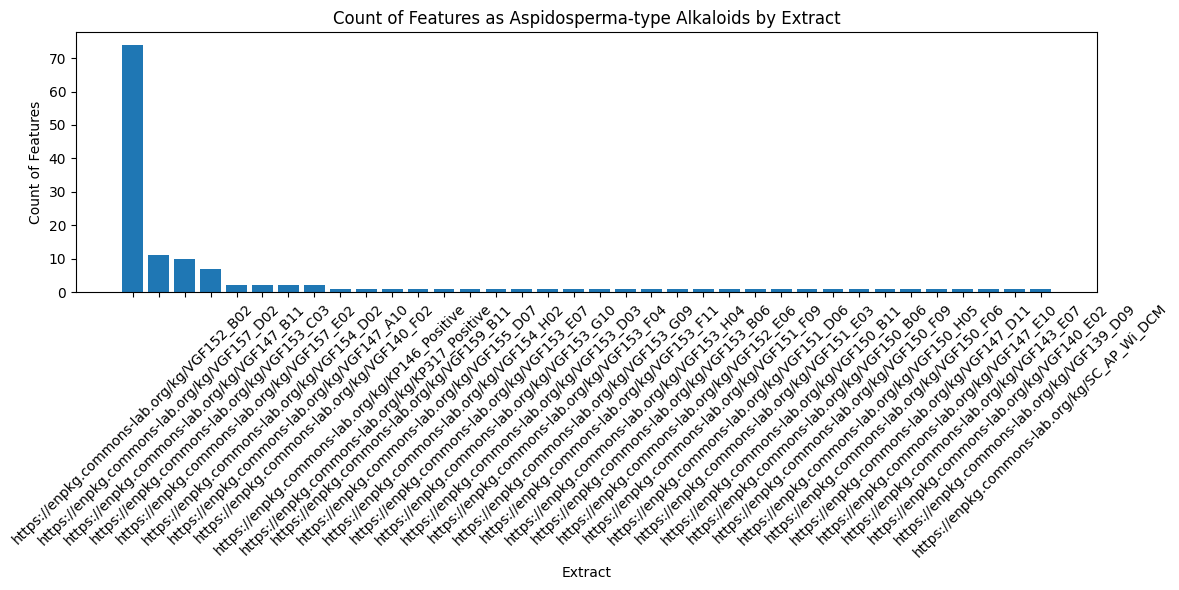

The bar chart above visualizes the count of features as aspidosperma-type alkaloids for different extracts. Each bar represents the count of features for a specific extract.

2024-03-14 15:59:43,908 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The bar chart visualizes the count of features annotated as aspidosperma-type alkaloids for different extracts, with each bar representing the count of features for a specific extract. The extracts are ordered by the decreasing count of features as aspidosperma-type alkaloids, showcasing the distribution and highlighting the extracts with the highest number of such features.

> Finished chain.


2024-03-14 15:59:48,924 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__end__': {'messages': [HumanMessage(content='Which extracts have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids? Group by extract and provide a bar chart.'), HumanMessage(content='The resolved entity for the chemical class "aspidosperma-type alkaloids" is the IRI: https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass. There are no units relevant to numerical values in this question.', name='ENPKG_agent'), HumanMessage(content='The extracts that have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids, are as follows:\n\n1. Extract [VGF152_B02](https://enpkg.commons-lab.org/kg/VGF152_B02) with 74 features.\n2. Extract [VGF157_D02](https://enpkg.commons-lab.org/kg/VG

In [221]:
for s in app.stream(
    {"messages": [HumanMessage(content=q2)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

In [245]:
for s in app.stream(
    {"messages": [HumanMessage(content=q2)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

2024-03-15 11:50:14,423 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 11:50:16,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `CHEMICAL_RESOLVER` with `{'query': 'aspidosperma-type alkaloids'}`




> Entering new ChemicalResolver chain...
InChIKey not found, trying NPC Classifier


2024-03-15 11:50:20,170 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-15 11:50:23,774 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-15 11:50:25,412 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-15 11:50:28,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.
aspidosperma-type alkaloids : https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass

2024-03-15 11:50:28,862 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entity for the chemical class "aspidosperma-type alkaloids" is the IRI: https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass. There are no units relevant to numerical values in this question.

> Finished chain.


2024-03-15 11:50:32,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 11:50:34,848 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'Which extracts have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids? Group by extract.', 'entities': 'aspidosperma-type alkaloids, https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass'}`




> Entering new GraphSparqlQAChain chain...


2024-03-15 11:50:51,411 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
SELECT ?extract (COUNT(?feature) AS ?count)
WHERE {
    ?extract ns1:has_LCMS ?analysis .
    ?analysis a ns1:LCMSAnalysisPos .
    ?analysis ns1:has_lcms_feature_list ?featureList .
    ?featureList ns1:has_lcms_feature ?feature .
    ?feature ns1:has_canopus_annotation ?annotation .
    ?annotation a ns1:SiriusCanopusAnnotation .
    ?annotation ns1:has_canopus_npc_class <https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type> .
    ?annotation ns1:has_canopus_npc_class_prob ?prob .
    FILTER(?prob > 0.5)
}
GROUP BY ?extract
ORDER BY DESC(?count)
Saving results to file:  /var/folders/20/4kgcw5656h12ss_nj18mndwm0000gn/T/tmpfr8goxec.csv

> Finished chain.
{'query': 'PREFIX ns1: <https://enpkg.commons-lab.org/kg/>\nPREFIX ns2: <https://enpkg.commons-lab.org/module/>\nSELECT ?extract (COUNT(?feature) AS ?count)\nWHERE {\n    ?extract ns1:has_LCMS ?analysis .\n    ?analys

2024-03-15 11:50:52,734 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The extracts that have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids, are as follows:

1. Extract [VGF152_B02](https://enpkg.commons-lab.org/kg/VGF152_B02) with 74 features.
2. Extract [VGF157_D02](https://enpkg.commons-lab.org/kg/VGF157_D02) with 11 features.
3. Extract [VGF147_B11](https://enpkg.commons-lab.org/kg/VGF147_B11) with 10 features.
4. Extract [VGF153_C03](https://enpkg.commons-lab.org/kg/VGF153_C03) with 7 features.
5. Extract [VGF157_E02](https://enpkg.commons-lab.org/kg/VGF157_E02) with 2 features.
6. Extract [VGF154_D02](https://enpkg.commons-lab.org/kg/VGF154_D02) with 2 features.
7. Extract [VGF147_A10](https://enpkg.commons-lab.org/kg/VGF147_A10) with 2 features.
8. Extract [VGF140_F02](https://enpkg.commons-lab.org/kg/VGF140_F02) with 2 features.
9. Extract [KP146_Positive](https://enpkg.commons-lab.org/kg/K

2024-03-15 11:51:28,898 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__end__': {'messages': [HumanMessage(content='Which extracts have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids? Group by extract.'), HumanMessage(content='The resolved entity for the chemical class "aspidosperma-type alkaloids" is the IRI: https://enpkg.commons-lab.org/kg/npc_Aspidosperma_type, NPCClass. There are no units relevant to numerical values in this question.', name='ENPKG_agent'), HumanMessage(content='The extracts that have features (pos ionization mode) annotated as the class, aspidosperma-type alkaloids, by CANOPUS with a probability score above 0.5, ordered by the decreasing count of features as aspidosperma-type alkaloids, are as follows:\n\n1. Extract [VGF152_B02](https://enpkg.commons-lab.org/kg/VGF152_B02) with 74 features.\n2. Extract [VGF157_D02](https://enpkg.commons-lab.org/kg/VGF157_D02) with 11 featur

In [269]:
for s in app.stream(
    {"messages": [HumanMessage(content=q6)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

2024-03-15 15:20:52,343 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 15:20:53,620 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `TAXON_RESOLVER` with `{'taxon_name': 'Melochia umbellata'}`


wikidata IRI is http://www.wikidata.org/entity/Q6813281

2024-03-15 15:20:55,439 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The resolved entity for the taxon "Melochia umbellata" is the Wikidata IRI: http://www.wikidata.org/entity/Q6813281

The units relevant to the numerical values in the question are:
- "retention time": "seconds"
- "parent mass": "ppm (parts-per-million) for m/z"

> Finished chain.


2024-03-15 15:20:59,635 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-03-15 15:21:01,111 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Invoking: `SPARQL_QUERY_RUNNER` with `{'question': 'Filter the pos ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS to keep the ones for which a feature in neg ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm).', 'entities': 'taxon: http://www.wikidata.org/entity/Q6813281'}`




> Entering new GraphSparqlQAChain chain...


2024-03-15 15:21:28,413 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated SPARQL:
PREFIX ns1: <https://enpkg.commons-lab.org/kg/>
PREFIX ns2: <https://enpkg.commons-lab.org/module/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?posFeature ?negFeature
WHERE {
    ?rawMaterial ns1:has_wd_id <http://www.wikidata.org/entity/Q6813281> .
    ?rawMaterial ns1:has_lab_process ?labExtract .
    ?labExtract ns1:has_LCMS ?posAnalysis .
    ?posAnalysis a ns1:LCMSAnalysisPos .
    ?posAnalysis ns1:has_lcms_feature_list ?posFeatureList .
    ?posFeatureList ns1:has_lcms_feature ?posFeature .
    ?posFeature ns1:has_sirius_adduct "[M+H]+" .
    ?posFeature ns1:has_retention_time ?posRetentionTime .
    ?posFeature ns1:has_parent_mass ?posParentMass .
    ?labExtract ns1:has_LCMS ?negAnalysis .
    ?negAnalysis a ns1:LCMSAnalysisNeg .
    ?negAnalysis ns1:has_lcms_feature_list ?negFeatureList .
    ?negFeatureList ns1:has_lcms_feature ?negFeature .
    ?negFeature ns1:has_sirius_adduct "[M-H]-" .
    ?negFeature ns1:has_retention_time ?negRetentionTime

2024-03-15 15:21:31,483 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The query was executed to filter the positive ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS, keeping only those for which a feature in negative ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm). However, no matching features were found in the database.

Here is the summary of the process:
- **Question:** Filter the pos ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS to keep the ones for which a feature in neg ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm).
- **Generated SPARQL Query:** The query was designed to select positive and corresponding negative ionization mode features based on the specified criteria.
- **File Path:** The results were expected to be stored in a temporary file, but no matching records were found, hence no file was created.

2024-03-15 15:21:50,427 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__end__': {'messages': [HumanMessage(content='Filter the pos ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS to keep the ones for which a feature in neg ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm).'), HumanMessage(content='The resolved entity for the taxon "Melochia umbellata" is the Wikidata IRI: http://www.wikidata.org/entity/Q6813281\n\nThe units relevant to the numerical values in the question are:\n- "retention time": "seconds"\n- "parent mass": "ppm (parts-per-million) for m/z"', name='ENPKG_agent'), HumanMessage(content='The query was executed to filter the positive ionization mode features of the Melochia umbellata taxon annotated as [M+H]+ by SIRIUS, keeping only those for which a feature in negative ionization mode is detected with the same retention time (+/- 3 seconds) and a mass corresponding to the [M-H]- adduct (+/- 5ppm). However, no matching fe

In [ ]:
for s in app.stream(
    {"messages": [HumanMessage(content=q3)]},
    {"recursion_limit": 100},
):
    if "__end__" in s:
        print(s)
        print("----")

In [ ]:
def process_stream(app, q2):
    results = []  # Initialize an empty list to store results
    try:
        # Iterate over the stream from app.stream()
        for s in app.stream(
            {
                "messages": [
                    HumanMessage(
                        content=q2
                    )  # Assuming q2 is the content of the message
                ]
            },
            {"recursion_limit": 100},  # Additional options for the stream
        ):
            # Check if "__end__" is not in the stream output
            if "__end__" not in s:
                results.append(
                    s
                )  # Append the stream output to results list instead of printing
    except Exception as e:
        print(f"An error occurred: {e}")
    return results  # Return the list of results

In [ ]:
def process_stream(question):
    """
    Iterates over messages from app.stream(), printing each message until an "__end__" flag is encountered.

    :param question: The question to be sent as part of the initial stream request.
    """
    # Define the parameters for app.stream() as described
    stream_params = {
        "messages": [{"content": question}],
    }
    stream_options = {"recursion_limit": 100}

    try:
        for s in app.stream(stream_params, stream_options):
            if "__end__" not in s:
                print(s)
                print("----")
            else:
                break  # Exit the loop if "__end__" is encountered
    except Exception as e:
        print(f"An error occurred during streaming: {e}")